In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import csv

import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from pitch_tracker.utils import files, dataset
from pitch_tracker.utils.constants import SAMPLE_RATE, PICKING_FRAME_SIZE, RANDOM_STATE

import medleydb


In [3]:
stft_hop_size = 512
step_frame = 5
onset_frame_time = stft_hop_size*step_frame/SAMPLE_RATE
pick_frame_time = PICKING_FRAME_SIZE * onset_frame_time

DATASET_DIR = f'../content/pickled_database/{stft_hop_size}_{step_frame}/'
DATA_SPLIT_PATH = dataset.DATA_SPLIT_PATH


In [4]:
train_df, validation_df, test_df = dataset.split_dataset_df('thesis', pickled_data_dir=DATASET_DIR)

Missing tracks: 0 []
Missing tracks: 0 []
train_set: 54
validation_set: 27
test_set: 27


In [5]:
train_df.head(5)

,track_id,artist,predominant_instrument,melody2_instruments,genre,duration,has_bleed,pickled_path
16,JoelHelander_ExcessiveResistancetoChange,JoelHelander,tack piano,"[tack piano, clarinet, piano, violin]",Classical,250.180952,True,../content/pickled_database/512_5/JoelHelander...
22,LizNelson_Rainfall,LizNelson,female singer,[female singer],Singer/Songwriter,284.908844,False,../content/pickled_database/512_5/LizNelson_Ra...
79,SecretMountains_HighHorse,SecretMountains,female singer,"[clean electric guitar, female singer]",Pop,355.500408,False,../content/pickled_database/512_5/SecretMounta...
50,MusicDelta_Punk,MusicDelta,male singer,[male singer],Rock,28.762540,False,../content/pickled_database/512_5/MusicDelta_Punk
1,AlexanderRoss_GoodbyeBolero,AlexanderRoss,male singer,"[harmonica, male singer, brass section, clean ...",Singer/Songwriter,418.816757,False,../content/pickled_database/512_5/AlexanderRos...


# Dataset distribution

## Genres

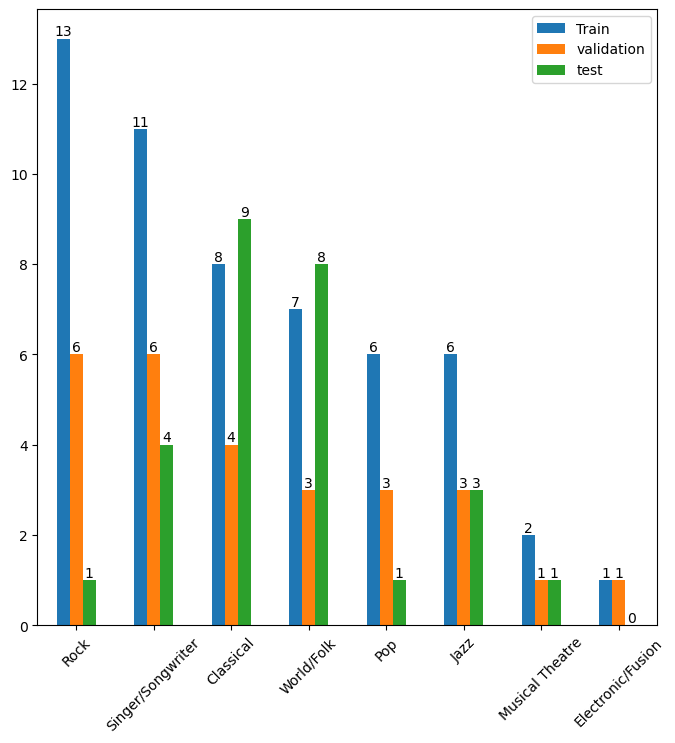

In [6]:
def plot_bars(dfs, figsize=(8, 8)):
    df = pd.concat(dfs, axis=1)
    fig, ax = plt.subplots(figsize=figsize)
    df.plot.bar(rot=45, ax=ax)
    for i in ax.containers:
        ax.bar_label(i)
    plt.show()

series = []
s = train_df['genre'].value_counts()
s.name = "Train"
series.append(s)
s = validation_df['genre'].value_counts()
s.name = "validation"
series.append(s)
s = test_df['genre'].value_counts()
s.name = "test"
series.append(s)

plot_bars(series) 

## Duration

In [7]:
## This commented code will calculate the number of pick_frames using duration 
# train_samples = ((train_df['duration'] / pick_frame_time)+0.5).astype(int).sum()
# validation_samples =((validation_df['duration'] / pick_frame_time)+0.5).astype(int).sum()
# test_samples =((test_df['duration'] / pick_frame_time)+0.5).astype(int).sum()

train_samples = sum([len(files.list_all_file_paths_in_dir(dir_path)) for dir_path in train_df['pickled_path']])
validation_samples = sum([len(files.list_all_file_paths_in_dir(dir_path)) for dir_path in validation_df['pickled_path']])
test_samples = sum([len(files.list_all_file_paths_in_dir(dir_path)) for dir_path in test_df['pickled_path']])

In [8]:
total_samples = train_samples+validation_samples+test_samples
print('Number of frame')
print(f'train: {train_samples}')
print(f'validation: {validation_samples}')
print(f'test: {test_samples}')
print(f'ratio: {train_samples/total_samples:.2f}/{validation_samples/total_samples:.2f}/{test_samples/total_samples:.2f}')

Number of frame
train: 1451
validation: 763
test: 945
ratio: 0.46/0.24/0.30


# Dataset & dataloader

In [9]:
train_set = train_df['pickled_path']
validation_set = validation_df['pickled_path']
test_set = test_df['pickled_path']

In [10]:
train_dataset = dataset.AudioDataset(train_set)
validation_set = dataset.AudioDataset(validation_set)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(validation_set, batch_size=8, shuffle=True)

In [11]:
feature, label = next(iter(train_dataloader))

In [12]:
print(feature.shape)

torch.Size([8, 1, 1050, 88])
